In [1]:
import tensorflow as tf
print(tf.test.gpu_device_name())

config = tf.ConfigProto()
config.gpu_options.allow_growth = True

/device:GPU:0


In [2]:
import json, time, re, string, keras, adanet, pickle
import pandas as pd
import psycopg2 as pg2
import numpy as np
import tensorflow as tf

from numpy import random
from psycopg2.extras import RealDictCursor, Json
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM
from keras.utils.np_utils import to_categorical

import matplotlib.pyplot as plt

%matplotlib inline
%run ../assets/sql_cred.py

Using TensorFlow backend.
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/psycopg2/__init__.py:144: UserWarning: The psycopg2 wheel package will be renamed from release 2.8; in order to keep installing from binary please use "pip install psycopg2-binary" instead. For details see: <http://initd.org/psycopg/docs/install.html#binary-install-from-pypi>.
  """)


In [3]:
def filename_format_log(file_path, 
                        logfile = '../assets/file_log.txt', 
                        now = round(time.time()), 
                        file_description = None): 
   
    try:
        ext = re.search('(?<!^)(?<!\.)\.(?!\.)', file_path).start() 
    except:
        raise NameError('Please enter a relative path with a file extension.') 
    
    stamp = re.search('(?<!^)(?<!\.)[0-z]+_[0-z]+(?=\.)', file_path).start()
    formatted_name = f'{file_path[:stamp]}{now}_{file_path[stamp:]}'  
    if not file_description:
        file_description = f'Saved at: {time.asctime(time.gmtime(now))}'
    with open(logfile, 'a+') as f:
        f.write(f'{formatted_name}: {file_description}\n')
    return formatted_name, now, file_description

In [4]:
def con_cur_to_db(dbname=DBNAME, dict_cur=None):
    con = pg2.connect(host=IP_ADDRESS,
                  dbname=dbname,
                  user=USER,
                  password=PASSWORD)
    if dict_cur:
        cur = con.cursor(cursor_factory=RealDictCursor)
    else:
        cur = con.cursor()
    return con, cur
    
def execute_query(query, dbname=DBNAME, dict_cur=None, command=False):
    con, cur = con_cur_to_db(dbname, dict_cur)
    cur.execute(f'{query}')
    if not command:
        data = cur.fetchall()
        con.close()
        return data
    con.commit() #sends to server
    con.close() #closes server connection

In [5]:
lyric_df = pd.read_csv('../assets/1548873539_clean_lyrics.csv')

In [6]:
lyric_df.head()

,lyrics,clean_text
0,\n\nIf your needle is near\nNeedle is near\nYo...,if your needle is near \n needle is near \n yo...
1,\n\n[Verse 1]\nBrown skin girl on the other si...,brown skin girl on the other side of the room ...
2,"\n\n[Verse 1]\nIt's simple, I love it\nHaving ...",its simple i love it \n having you near me hav...
3,\n\n[Intro: Whistling]\n\n[Verse 1]\nA great b...,a great big bang and dinosaurs \n fiery rainin...
4,\n\n[Verse 1]\nIsn't she lovely\nIsn't she won...,isnt she lovely \n isnt she wonderful \n isnt ...


In [7]:
lyric_df = lyric_df.drop(index=[193], axis=0)

In [8]:
lyric_df.describe()

,lyrics,clean_text
count,1800,1800
unique,1800,1800
top,"\n\n[Verse 1: Jamie Paige]\nWhoa, yeah I got t...",i wanna thank you for you makin life so tough ...
freq,1,1


In [9]:
lyric_df[lyric_df['clean_text'].str.contains(r'(\s{6,})')]

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  """Entry point for launching an IPython kernel.


,lyrics,clean_text
31,\n\n3/3\nBoy Rex - The Bloodmonths - 8/8\nJoey...,boy rex the bloodmonths \n joey fatts ill ...
142,"\n\n[Verse 1]\nJenny, Jenny, who can I turn to...",jenny jenny who can i turn to \n you give me s...
195,\n\n[NEW] 1. TWICE - What Is Love?\n[NEW] 2. ...,twice what is love \n exocbx blooming day ...
260,\n\n[Verse 1]:\nElectric lights\nBlow my mind\...,electric lights \n blow my mind \n i feel alri...
552,"\n\nBaby, baby yea\nYou run on my mind yea\nSa...",baby baby yea \n you run on my mind yea \n sam...
938,\n\n[Verse 1]\nThere are two of us on the run\...,there are two of us on the run \n going so fas...
960,"\n\n[Verse 1]\nYou're my baby, my lover, my la...",youre my baby my lover my lady \n all night yo...
1106,\n\nORIGINALTracklist1. Let's Go Crazy\n2. T...,originaltracklist lets go crazy \n take me ...
1169,\n\n[Intro-Live Acoustic]\nKnow your place amo...,know your place among the dark arms of the woo...
1495,\n\n[Verse 1]\nIt was a day\nJust like any oth...,it was a day \n just like any other day \n i w...


In [10]:
lyric_df = lyric_df.drop(index=1768, axis=0)

In [11]:
def split_sequence(text, sequence_length = 7, output_length = 4):
    
    X, y = [], []
    
    split_text = re.split('(\n)|(\[.+\])|\s', text)
    split_text = list(filter(None, split_text))
    split_text = text
    
    for i in range(len(split_text) - sequence_length):
        X.append(split_text[i:i + sequence_length])
        y.append(split_text[i + sequence_length:i + sequence_length + output_length])
        
    return X, y

In [12]:
# tokenize_lyrics(
df=lyric_df
lyrics_col=['clean_text']
seq_len=4 
output_len=1
save_dir='../assets'
# )

X = []
y = []

corpus = []

print('Processing lyrics...')
for _, track in df[lyrics_col].iterrows():
    lyrics = track[0]
    lyrics_spaced = re.sub(r'( +)', ' ', lyrics)
    lyrics_split = lyrics_spaced.split(' ')
    corpus.extend(lyrics_split)

    for i in range(len(lyrics_split) - seq_len):
        X.append(np.array(lyrics_split[i:i + seq_len]))
        y.extend(np.array(lyrics_split[i + seq_len:i + seq_len + output_len]))

print('Creating encoding dicts from corpus...')
words = sorted(list(set(corpus)))

Processing lyrics...
Creating encoding dicts from corpus...


In [13]:
print(f'Count of unique words (i.e., features): {len(words)}')
words_index = dict((c, i+1) for i, c in enumerate(words))
index_words = dict((i+1, c) for i, c in enumerate(words))

Count of unique words (i.e., features): 13468


In [14]:
#         formatted_name, now, file_description= filename_format_log(f'{save_dir}/tokenizer.pkl')

#         with open(formatted_name, 'wb+') as f:
#             pickle.dump(tokenizer, f)
#         print(f'Tokenizer saved to {formatted_name}.')          

In [15]:
print('Indexing sequences...')
X_indexed = [[words_index[word] for word in row] for row in X]
y_indexed = [words_index[word] for word in y]
print('Number of sequences')
print('Partitioning and converting to labels...')

Indexing sequences...
Number of sequences
Partitioning and converting to labels...


In [16]:
#     partition, labels = generate_samples(X_indexed, y_indexed)

#     np.save(f'{save_dir}/data.npy', partition)
X_reshape = np.reshape(X_indexed, (len(X_indexed), seq_len))

y_cat = to_categorical(y_indexed)

print('Lyrics successfully tokenized, sequenced, and indexed.') 

Lyrics successfully tokenized, sequenced, and indexed.


In [17]:
def generate_samples(X_indexed, y_cat, seq_len=4, random_seed = 42):
    X_train = [] 
    X_test = []
    y_train = []
    y_test = []
    
    rand_ind = random.choice(range(len(X_indexed)), len(X_indexed), replace=False)
    
    train_ind = rand_ind[:int(np.ceil(len(rand_ind)*.8))]
    test_ind = rand_ind[-int(np.ceil(len(rand_ind)*.2))+1:]

    for i in train_ind:
        X_train.append(X_indexed[i])
        y_train.append(y_cat[i])
        
    for i in test_ind:
        X_test.append(X_indexed[i])
        y_test.append(y_cat[i])
        
    return np.reshape(X_train, (len(X_train), seq_len, 1)) , np.reshape(X_test, (len(X_test), seq_len, 1)), np.array(y_train), np.array(y_test)

In [ ]:
# X_train, X_test, y_train, y_test = generate_samples(X_indexed, y_cat)

In [49]:
type(X_reshape)

numpy.ndarray

In [46]:
X_reshape.shape

(576641, 4, 1)

In [28]:
X_reshape

array([[ 5600, 13417,  7788,  5877],
       [13417,  7788,  5877,  7769],
       [ 7788,  5877,  7769,     1],
       ...,
       [13408,     1,  6862,  7170],
       [    1,  6862,  7170,  6125],
       [ 6862,  7170,  6125,  6862]])

In [48]:
type(y_cat)

numpy.ndarray

In [51]:
type(y_train)

list

In [17]:
# Compile model
model = Sequential()
model.add(Embedding(len(words)+1, 3000, mask_zero=True))
model.add(LSTM(150, return_sequences=True))
model.add(LSTM(50))
model.add(Dense(100, activation='relu'))
model.add(Dense(y_cat.shape[1], activation='softmax'))

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy'])

In [25]:
# Train model on dataset
with tf.device('/gpu:0'):
    history = model.fit(X_reshape,
              y_cat,
              verbose=1,
              batch_size=5000,
              epochs=300
             )

Epoch 1/300
576641/576641 [==============================] - 78s 135us/step - loss: 5.8014 - acc: 0.1237
Epoch 2/300
576641/576641 [==============================] - 78s 135us/step - loss: 5.7650 - acc: 0.1237
Epoch 3/300
576641/576641 [==============================] - 78s 135us/step - loss: 5.6198 - acc: 0.1236
Epoch 4/300
576641/576641 [==============================] - 78s 135us/step - loss: 5.3189 - acc: 0.1534
Epoch 5/300
576641/576641 [==============================] - 78s 135us/step - loss: 5.1014 - acc: 0.1691
Epoch 6/300
576641/576641 [==============================] - 78s 135us/step - loss: 4.9080 - acc: 0.1857
Epoch 7/300
576641/576641 [==============================] - 78s 135us/step - loss: 4.7522 - acc: 0.1993
Epoch 8/300
576641/576641 [==============================] - 78s 135us/step - loss: 4.6161 - acc: 0.2117
Epoch 9/300
576641/576641 [==============================] - 78s 135us/step - loss: 4.4946 - acc: 0.2240
Epoch 10/300
576641/576641 [===========================

In [27]:
# formatted_name, now, file_description= filename_format_log('../assets/LSTM_Model.pkl')

# with open(formatted_name, 'wb+') as f:
#     pickle.dump(model, f)

In [18]:
with open(f'../assets/1549265762_LSTM_Model.pkl', 'rb') as f:
    model = pickle.load(f)

In [19]:
# Print model summary
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 3000)        40407000  
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 150)         1890600   
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                40200     
_________________________________________________________________
dense_1 (Dense)              (None, 100)               5100      
_________________________________________________________________
dense_2 (Dense)              (None, 13469)             1360369   
Total params: 43,703,269
Trainable params: 43,703,269
Non-trainable params: 0
_________________________________________________________________
None


In [20]:
history = model.history

AttributeError: 'Sequential' object has no attribute 'history'

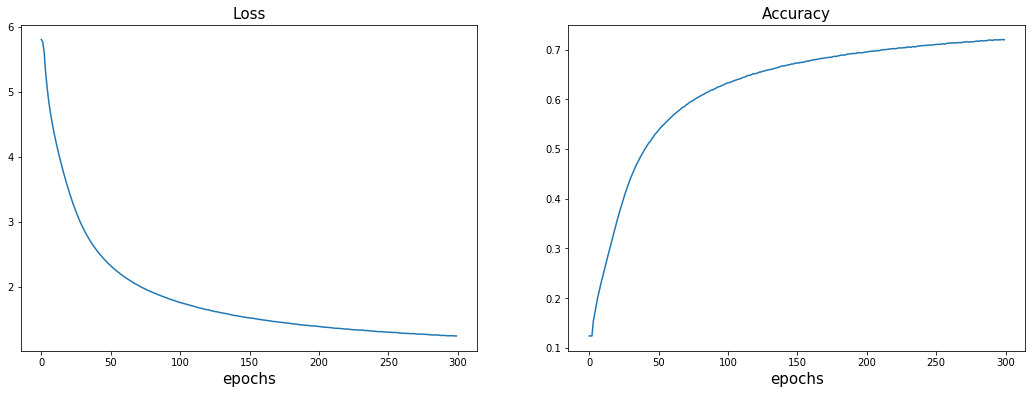

In [61]:
fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(18,6))

ax[0].plot(history.history['loss'])
ax[0].set_title("Loss", fontsize=15);
ax[0].set_xlabel("epochs",fontsize=15);

ax[1].plot(history.history['acc'])
ax[1].set_title("Accuracy",fontsize=15);
ax[1].set_xlabel("epochs",fontsize=15);

In [26]:
def generate_lyrics(seed, model=model, seq_len=4, song_len=50):
    seed_clean = seed.lower().split(' ')
    doc = []

    while len(doc) < song_len:
        text = seed_clean
        sequence = [words_index[word] for word in text]
        pad_sequence = pad_sequences(sequence, maxlen=seq_len, truncating='pre')
        sequence_reshape = np.reshape(pad_sequence, ((len(sequence)/4), seq_len, 1))

        yhat = model.predict_classes(sequence_reshape, verbose=0)

        for word, index in index_words.items():
            if index == yhat:
                seed_clean.append(word)
                doc.append(word)

    return ' '.join(doc)

In [27]:
lyrics = generate_lyrics('eyes are for lovers', song_len=150)

ValueError: `sequences` must be a list of iterables. Found non-iterable: 3906

In [24]:
lyrics

['eyes', 'are', 'for', 'lovers']

In [25]:
[words_index[word] for word in lyrics]

[3906, 456, 4327, 6871]

In [49]:
words_index['lovers']

6871